# Analysis of the Spanish football league (La Liga)

In [4]:
import re
import requests
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from urllib.parse import urljoin

import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Web data extraction

The historical data of La Liga (from 1929 until 2022) was scraped from www.bdfutbol.com. This website contains national and international football rankings. 
To scrape the data, we have used BeautifulSoup which is a popular Python library for extracting information from an HTML page. After obtaining all the data, we have stored it in a Pandas data frame for further processing.

In [5]:
base_url = 'https://www.bdfutbol.com/en/t/t.html'
response = requests.get(base_url)
soup = BeautifulSoup(response.text, 'html.parser')
div = soup.find('div', class_='bloc_temporades')
links = [a['href'] for a in div.find_all('a')]

data = []

for link in links:
    print(int(link[1:5]) + 1)
    url = urljoin(base_url, link)
    response = requests.get(url)

    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', id='classific')
    rows = table.find_all('tr')

    for row in rows[1:]:
        values = [cell.text for cell in row.find_all('td')[1:]]
        values.insert(0, int(link[1:5]) + 1)
        data.append(values)

2022
2021
2020
2019
2018
2017
2016
2015
2014
2013
2012
2011
2010
2009
2008
2007
2006
2005
2004
2003
2002
2001
2000
1999
1998
1997
1996
1995
1994
1993
1992
1991
1990
1989
1988
1987
1986
1985
1984
1983
1982
1981
1980
1979
1978
1977
1976
1975
1974
1973
1972
1971
1970
1969
1968
1967
1966
1965
1964
1963
1962
1961
1960
1959
1958
1957
1956
1955
1954
1953
1952
1951
1950
1949
1948
1947
1946
1945
1944
1943
1942
1941
1940
1936
1935
1934
1933
1932
1931
1930
1929


## Convert data list to dataframe

In [6]:
df = pd.DataFrame (data, columns = ['Year','Rank','unNamed','Team','Pts','P','W','D','L','F','A','YC', 'RD'])
df.head()

,Year,Rank,unNamed,Team,Pts,P,W,D,L,F,A,YC,RD
0,2022,1,,Real Madrid,86,38,26,8,4,80,31,76,0
1,2022,2,,Barcelona,73,38,21,10,7,68,38,94,5
2,2022,3,,Atlético de Madrid,71,38,21,8,9,65,43,109,7
3,2022,4,,Sevilla,70,38,18,16,4,53,30,96,4
4,2022,5,,Betis,65,38,19,8,11,62,40,86,6


# Data Cleaning

Data Cleaning is the process of transforming raw data into a standardized form that can easily be analyzed with data analytics tools.  In this particular case, before analyzing the data using Pandas, we have performed multiple cleaning operations. We have removed unnecessary columns and renamed the remaining ones using English terms (remember that data was scraped from a Spanish website). During the exploratory data analysis, we have noticed that in some cases multiple names were used to refer to the same football team.

### Remove old club names

In [7]:
# mapping dictionary - the keys contain old club names and the values are current club names
old_club_names = {'Unión Irún': 'Real Unión', 'Donostia': 'Real Sociedad', 'Athletic de Madrid': 'Atlético de Madrid',
                  'Madrid': 'Real Madrid', 'Alicante CD': 'Hércules', 'Atlético Aviación': 'Atlético de Madrid',
                  'Gimnástico de Tarragona': 'Gimnàstic de Tarragona', 'Lérida': 'Lleida', 'Santander': 'Racing de Santander',
                  'Real Gijón': 'Sporting de Gijón', 'Atlético de Bilbao': 'Athletic Club', 'CD Málaga': 'Málaga',
                  'Español': 'Espanyol'}

# replace old club denominations by current denominations
df.replace(old_club_names, inplace=True)

### Drop unnecessary columns

In [8]:
# drop the column Unnamed:1 - this column does not contain valuable information
df = df.drop(['unNamed', 'P', 'YC', 'RD'], axis=1)
df.head()

,Year,Rank,Team,Pts,W,D,L,F,A
0,2022,1,Real Madrid,86,26,8,4,80,31
1,2022,2,Barcelona,73,21,10,7,68,38
2,2022,3,Atlético de Madrid,71,21,8,9,65,43
3,2022,4,Sevilla,70,18,16,4,53,30
4,2022,5,Betis,65,19,8,11,62,40


### Number of teams

In [9]:
print("Number of Teams: {}" .format(len(df['Team'].unique())))

Number of Teams: 64


In [10]:
col_names = df.columns
for col in col_names[1:]:
    if col != 'Team':
        values = df[col].tolist()
        num_values = [int(re.findall(r'\d+', value)[0]) for value in values]
        df[col] = num_values
df.to_csv('data.csv')  
df.head()

,Year,Rank,Team,Pts,W,D,L,F,A
0,2022,1,Real Madrid,86,26,8,4,80,31
1,2022,2,Barcelona,73,21,10,7,68,38
2,2022,3,Atlético de Madrid,71,21,8,9,65,43
3,2022,4,Sevilla,70,18,16,4,53,30
4,2022,5,Betis,65,19,8,11,62,40


In [11]:
df.describe()

,Year,Rank,Pts,W,D,L,F,A
count,1562.000000,1562.000000,1562.00000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000
mean,1981.170294,9.287452,38.49872,12.752881,8.034571,12.752881,47.636364,47.636364
std,25.567846,5.365318,15.57928,4.818992,3.576395,4.582129,15.296838,12.474585
min,1929.000000,1.000000,9.00000,2.000000,0.000000,0.000000,15.000000,15.000000
25%,1960.000000,5.000000,28.00000,10.000000,5.000000,10.000000,37.000000,39.000000
50%,1983.000000,9.000000,35.00000,12.000000,8.000000,13.000000,45.000000,47.000000
75%,2003.000000,14.000000,46.00000,15.000000,11.000000,16.000000,55.000000,56.000000
max,2022.000000,22.000000,100.00000,32.000000,18.000000,29.000000,121.000000,134.000000


### Rename the column names

In [12]:
# rename the columns 
df.rename({'Pts': 'Points', 'W': 'Win', 'D': 'Draws', 'L': 'Loss', 'F': 'Goals For',
                  'A': 'Goals Against'}, axis=1, inplace=True)
df.head()

,Year,Rank,Team,Points,Win,Draws,Loss,Goals For,Goals Against
0,2022,1,Real Madrid,86,26,8,4,80,31
1,2022,2,Barcelona,73,21,10,7,68,38
2,2022,3,Atlético de Madrid,71,21,8,9,65,43
3,2022,4,Sevilla,70,18,16,4,53,30
4,2022,5,Betis,65,19,8,11,62,40


# EDA

### Spanish league winners
The Spanish league has been played by more of 60 different clubs; however, only nine of them got their hands on the trophy. The following plot shows the Spanish league winners from season 1928–29 until 2021–22.

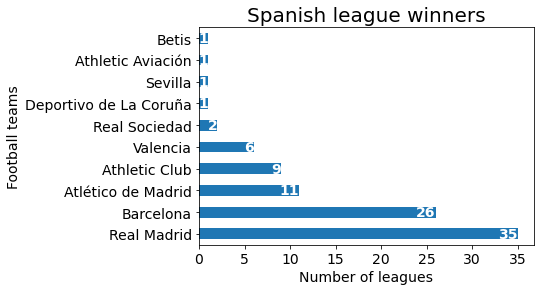

In [13]:
# teams that won la liga española
first_position = df[df['Rank'] == 1]['Team'].value_counts()

# plot labels indicating the number of leagues
for i, value in enumerate(first_position):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=14)

# plot the results using an horizontal bar plot
first_position.plot(kind='barh')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Number of leagues', fontsize=14)
plt.ylabel('Football teams', fontsize=14)
plt.title('Spanish league winners', fontsize=20);

As shown above, Real Madrid is the most successful club in the history of La Liga with 35 titles followed by Barcelona with 26 leagues. However, as we will see later, Barcelona is catching up. Apart from these two clubs, the Spanish first division has been won by other 7 clubs, including Atlético Madrid (11), Athletic Club (9), Valencia (6), Real Sociedad (2), Betis (1), Sevilla (1), and Deportivo de La Coruña (1).

### Spanish league runner-ups
Runner-ups meaning finishing the league in the 2nd place. Which means the team was just 1 place behind the winner of the season.

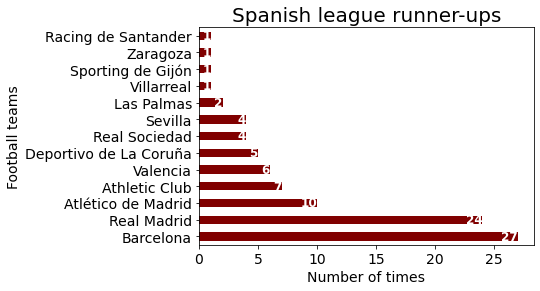

In [14]:
# spanish league runner-ups
second_position = df[df['Rank'] == 2]['Team'].value_counts()

# plot labels indicating the number times the team was runner-up
for i, value in enumerate(second_position):
     plt.text(value, i, str(value), horizontalalignment='right', verticalalignment='center', weight='bold', color='white', fontsize=12)

# plot the results using an horizontal bar plot
second_position.plot(kind='barh', color='maroon')

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('Number of times', fontsize=14)
plt.ylabel('Football teams', fontsize=14)
plt.title('Spanish league runner-ups', fontsize=20);

### Total number of seasons in the first division (Top 10)
There are only 3 football teams that have never been relegated to the second division: Athletic Club, Barcelona, and Real Madrid. Espanyol and Valencia played 4 seasons in the second division, and Atlético de Madrid 6.

All teams from the image below are currently in the first division with the exception of Zaragoza (since 2012–13 in the second division).

Text(0, 0.5, 'Number of seasons')

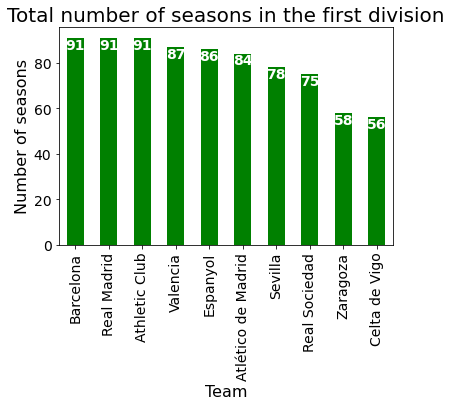

In [15]:
# total number of seasons in the first division (top 10)
number_of_seasons = df.groupby('Team').count().Rank.sort_values(ascending=False).head(10)

# plot labels indicating the number of seasons in the first division
for i,value in enumerate(number_of_seasons):
     plt.text(i, value, str(value), horizontalalignment='center',verticalalignment='top', weight='bold', color='white', fontsize=14)

# plot the results using an horizontal bar plot
number_of_seasons.plot(kind='bar', color='green')

# modify the ticks 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Total number of seasons in the first division', fontsize=20)
plt.xlabel('Team', fontsize=16)
plt.ylabel('Number of seasons', fontsize=16)

### Number of teams in the Spanish league per year
The number of teams in La Liga has steadily increased from 10 to 20 teams with the exception of the seasons 1995–96 and 1996–97, during which 22 teams played.

Currently, 20 teams play the Spanish league. The same number of teams play the Serie A (Italy), the Ligue 1 (France), and the Premier League (England). On the contrary, 18 teams take part in the Bundesliga (Germany), the Primeira Liga (Portugal), and the Eredivisie (Holand).Evolution of the number of leagues

Text(0, 0.5, 'Number of clubs')

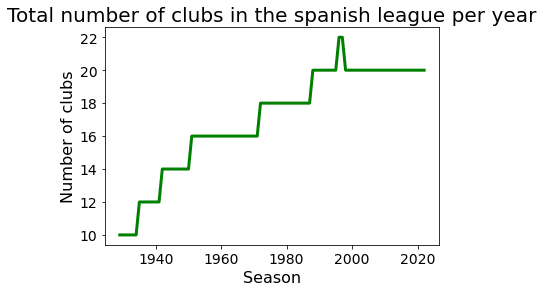

In [16]:
# number of teams in the Spanish league per season
number_clubs = df.groupby('Year').count().Team

# plot the results using a line plot
number_clubs.plot(linewidth=3, color='g')

# modify the ticks and the legend
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# define the title and the labels
plt.title('Total number of clubs in the spanish league per year', fontsize=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Number of clubs', fontsize=16)

# Predict rank using ML methods

### Construct data to predict rank

In [17]:
def get_Records(year, team, category):
    years = list(np.sort(df['Year'].unique()))
    year_index = years.index(year)
    
    df_year = df.loc[df['Year'] == year]
    year_team = df_year['Team'].tolist()
    year_value = df_year[category].tolist()
    
    if team in year_team:
        current_rank = year_team.index(team) + 1
        current_value = year_value[current_rank - 1]
        
        record = [team, year, category]
        for i in range(1, 6):
            prev_year = years[year_index - i];
            df_prev = df.loc[df['Year'] == prev_year]

            prev_team = df_prev['Team'].tolist()
            prev_value = df_prev[category].tolist()
            
            if team in prev_team:
                value = prev_value[prev_team.index(team)]
            else:
                if category == 'Rank':
                    value = 21
                elif category in ['Loss', 'Goal Against']:
                    value = max(prev_value)
                else:
                    value = min(prev_value)
                
            record.append(value)
        record.append(current_value)
    return record

In [18]:
col_names = ['Rank','Points','Win','Draws','Loss','Goals For','Goals Against']
years = np.sort(df['Year'].unique())

rec_data = []
for category in col_names:
    for year in years[5:]:
        df_year = df.loc[df['Year'] == year]
        year_team = df_year['Team'].tolist()
        year_pts = df_year['Points'].tolist()
        
        for team in year_team:
            rec_data.append(get_Records(year, team, category))

In [19]:
df_rec = pd.DataFrame (rec_data, columns = ['Team','Year','Category','X1','X2','X3','X4','X5','Y'])
df_rec.head()

,Team,Year,Category,X1,X2,X3,X4,X5,Y
0,Athletic Club,1934,Rank,2,2,1,1,3,1
1,Real Madrid,1934,Rank,1,1,6,5,2,2
2,Racing de Santander,1934,Rank,8,4,2,8,10,3
3,Betis,1934,Rank,5,21,21,21,21,4
4,Real Sociedad,1934,Rank,6,8,3,7,4,5


### Linear Regression with Rank Data

In [20]:
df_rank = df_rec[df_rec['Category'] == 'Rank']
X = df_rank[['X1','X2','X3','X4','X5']]
y = df_rank['Y']
df_rank.head()

,Team,Year,Category,X1,X2,X3,X4,X5,Y
0,Athletic Club,1934,Rank,2,2,1,1,3,1
1,Real Madrid,1934,Rank,1,1,6,5,2,2
2,Racing de Santander,1934,Rank,8,4,2,8,10,3
3,Betis,1934,Rank,5,21,21,21,21,4
4,Real Sociedad,1934,Rank,6,8,3,7,4,5


In [21]:
linear_reg_rank = linear_model.LinearRegression()
linear_reg_rank.fit(X, y)

LinearRegression()

In [22]:
def getRank(df1, yhat, category):
    df1['pred_rank'] = list(yhat)
    years = df1['Year'].unique()    
    for year in years:
        df_year = df1[df1['Year'] == year]
        y = df_year['pred_rank'].tolist()
        if category == 'Rank':
            pred_rank = [int(sorted(y).index(x) + 1) for x in y]
        else:
            pred_rank = [int(sorted(y, reverse=True).index(x) + 1) for x in y]
            
        df1.loc[df1['Year'] == year, 'pred_rank'] = pred_rank
    return df1        

#### Calculate MAE and RMSE

In [23]:
yhat = linear_reg_rank.predict(X)
df_rank = getRank(df_rank, yhat, 'Rank')
yhat = df_rank['pred_rank'].tolist()

MAE = mean_absolute_error(y, yhat)
RMSE = np.sqrt(mean_squared_error(y, yhat))
print("MAE: {}, RMSE: {}" .format(MAE, RMSE))

MAE: 3.3154761904761907, RMSE: 4.402455423580545


#### Predict rank in 2021-2022 

In [24]:
df_last = df[df['Year'] == 2022]
df_last['pred_rank'] = df_rank.loc[df_rank['Year'] == 2022, ('pred_rank')].tolist()
df_last = df_last[['Year','Team','Points','Win','Draws','Loss','Goals For','Goals Against','Rank','pred_rank']]
df_last

,Year,Team,Points,Win,Draws,Loss,Goals For,Goals Against,Rank,pred_rank
0,2022,Real Madrid,86,26,8,4,80,31,1,1.0
1,2022,Barcelona,73,21,10,7,68,38,2,3.0
2,2022,Atlético de Madrid,71,21,8,9,65,43,3,2.0
3,2022,Sevilla,70,18,16,4,53,30,4,4.0
4,2022,Betis,65,19,8,11,62,40,5,8.0
5,2022,Real Sociedad,62,17,11,10,40,37,6,5.0
6,2022,Villarreal,59,16,11,11,63,37,7,6.0
7,2022,Athletic Club,55,14,13,11,43,36,8,7.0
8,2022,Valencia,48,11,15,12,48,53,9,9.0
9,2022,Osasuna,47,12,11,15,37,51,10,13.0


### Linear Regression with points data

In [25]:
df_pts = df_rec[df_rec['Category'] == 'Points']
X = df_pts[['X1','X2','X3','X4','X5']]
y = df_pts['Y']
df_pts.head()

,Team,Year,Category,X1,X2,X3,X4,X5,Y
1512,Athletic Club,1934,Points,26,25,22,30,20,24
1513,Real Madrid,1934,Points,28,28,18,17,23,22
1514,Racing de Santander,1934,Points,14,20,22,14,9,19
1515,Betis,1934,Points,17,11,13,12,9,19
1516,Real Sociedad,1934,Points,15,14,22,14,20,18


In [26]:
linear_reg_pts = linear_model.LinearRegression()
linear_reg_pts.fit(X, y)

LinearRegression()

#### Calculate MAE and RMSE

In [27]:
yhat = linear_reg_pts.predict(X)
df_pts = getRank(df_pts, yhat, 'Points')
yhat = df_pts['pred_rank'].tolist()

y = df_rank['Y'].tolist()

MAE = mean_absolute_error(y, yhat)
RMSE = np.sqrt(mean_squared_error(y, yhat))
print("MAE: {}, RMSE: {}" .format(MAE, RMSE))

MAE: 3.2962962962962963, RMSE: 4.374650401753966


#### Predict rank in 2021-2022 

In [28]:
df_last = df[df['Year'] == 2022]
df_last['pred_rank'] = df_pts.loc[df_pts['Year'] == 2022, ('pred_rank')].tolist()
df_last = df_last[['Year','Team','Points','Win','Draws','Loss','Goals For','Goals Against','Rank','pred_rank']]
df_last

,Year,Team,Points,Win,Draws,Loss,Goals For,Goals Against,Rank,pred_rank
0,2022,Real Madrid,86,26,8,4,80,31,1,1.0
1,2022,Barcelona,73,21,10,7,68,38,2,2.0
2,2022,Atlético de Madrid,71,21,8,9,65,43,3,3.0
3,2022,Sevilla,70,18,16,4,53,30,4,4.0
4,2022,Betis,65,19,8,11,62,40,5,7.0
5,2022,Real Sociedad,62,17,11,10,40,37,6,5.0
6,2022,Villarreal,59,16,11,11,63,37,7,6.0
7,2022,Athletic Club,55,14,13,11,43,36,8,8.0
8,2022,Valencia,48,11,15,12,48,53,9,9.0
9,2022,Osasuna,47,12,11,15,37,51,10,15.0


# Summary
Trying to predict the rank using Linear regression seems to be pretty accurate. The errors when trying to predict using "Points" data or "Rank" data are quite equal so there is no advantage using one instead of the other. We have succesfully predicted 2022 Ranks for most teams or been very close to it and it is a good result that we are proud of.